# Covariance matrix adaptation evolution strategy (CMA-ES)

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


In [30]:
from typing import Optional
from collections.abc import Callable
from tqdm.auto import tqdm


def cma_es(
        problem: Callable[[torch.Tensor], torch.Tensor],
        dim: int = 20,
        stop_fitness: float = 1e-10,
        max_epochs: int = 10000,
        device: Optional[torch.device] = None,
        maximize: bool = False,
    ) -> dict:
    """(sample_size/mu_w, lambda)-CMA-ES — based on Hansen's 'purecmaes.m'"""

    # --- Initialization ---
    dim = torch.tensor(dim, device=device)                                  # n
    mean = torch.randn(dim, device=device)                                  # m
    sigma = torch.tensor(0.3, device=device)                                # σ

    # --- Strategy parameter setting: Selection ---
    population_size = 4 + int(3 * torch.log(dim))                           # λ = 4 + ⌊3 * ln(n)⌋
    sample_size = population_size // 2                                      # μ = λ / 2
    w = torch.log(torch.tensor(sample_size + 0.5, device=device)) - \
        torch.log(torch.arange(1, sample_size + 1, device=device))          # w_i = ln(μ + 0.5) - ln(i) for i = 1,...,μ
    w /= torch.sum(w)                                                       # Σ_i w_i = 1
    effective_sample_size = torch.sum(w)**2 \
        / torch.sum(w**2)                                                   # μ_eff = (Σ_i w_i)^2 / Σ_i w_i^2

    # -- Step-size control
    c_s = (effective_sample_size + 2) / (dim + effective_sample_size + 5)                    # c_σ = (μ_eff + 2) / (n + μ_eff + 5)
    d_s = 1 + 2 * max(0, torch.sqrt((effective_sample_size - 1) / (dim + 1)) - 1) + c_s      # d_σ = 1 + 2 * max(0, sqrt((μ_eff - 1) / (n + 1)) - 1) + c_σ
    c_m = 1                                                                                  # c_m

    # --- Covariance matrix adaptation ---
    a_cov = 2                                                                                # α_cov = 2
    c_c = (4 + effective_sample_size / dim) / (dim + 4 + 2 * effective_sample_size / dim)    # c_c = (4 + μ_eff / n) / (n + 4 + 2 * μ_eff / n)
    c_1 = a_cov / ((dim + 1.3)**2 + effective_sample_size)                                   # c_1 = α_cov / ((n + 1.3)^2 + μ_eff)
    c_mu = min(
        1 - c_1,  # NOTE: On the original formula, this 0.25 factor is not present for some reason.
        a_cov * (0.25 + effective_sample_size + (1 / effective_sample_size) - 2 ) / ((dim + 2)**2 + a_cov*effective_sample_size/2)
    )                                                                                        # c_μ = min(1 - c_1, α_cov * ((1/4) + μ_eff + 1 / μ_eff - 2) / ((n + 2)^2 + α_cov*μ_eff/2))

    # --- Initialize dynamic strategy parameters ---
    p_c = torch.zeros(dim, device=device)           # Evolution path of covariance matrix for rank-one update
    p_s = torch.zeros(dim, device=device)           # Conjugate evolution path
    B = torch.eye(dim, device=device)               # Orthonormal matrix of C's eigenvectors
    D = torch.ones(dim, device=device)              # Diagonal matrix of C's singular values
    C = B @ torch.diag(D ** 2) @ B.T                # Covariance matrix C
    invsqrtC = B @ torch.diag(D ** -1) @ B.T        # C^(-1/2)
    eigeneval = 0
    chiN = torch.sqrt(dim) * (1 - 1 / (4 * dim) + 1 / (21 * dim**2))  #  This is the Expected value of ||N(0,I)|| == norm(randn(N,1))

    # --- Generation Loop ---
    counteval = 0                                   # Number of evaluated individuals
    best_fitness_history = []
    mean_fitness_history = []
    for g in tqdm(range(1, max_epochs // population_size + 1), desc="Evolving", unit="gen"):
        if counteval >= max_epochs:
            break
        # Sample a new population of search points
        z = torch.randn(dim, population_size, device=device)
        y = B @ (D.unsqueeze(1) * z)
        x = mean.unsqueeze(1) + sigma * y

        # Evaluate the fitness of the samples and sort them (selection)
        fitness = problem(x.T)
        fitness_sort_index = torch.argsort(fitness, descending=maximize)
        fitness = fitness[fitness_sort_index]

        # Update the mean value (recombination)
        y_w = torch.sum(w * y[:, fitness_sort_index[:sample_size]], dim=1)
        mean = mean + c_m * sigma * y_w

        # Step-size control
        p_s = (1 - c_s) * p_s + torch.sqrt(c_s * (2 - c_s) * effective_sample_size) * invsqrtC @ y_w
        sigma *= torch.exp((c_s / d_s) * (torch.linalg.norm(p_s) / chiN - 1))

        # xold = mean.copy()

        # Covariance matrix adaptation
        h_s = torch.where(  # Heaviside step function
            torch.linalg.norm(p_s) / torch.sqrt(1 - (1 - c_s)**(2 * (g + 1)))
                <
            (1.4 + 2 / (dim + 1)) * chiN,
            torch.tensor(1.0, device=device),
            torch.tensor(0.0, device=device)
        )
        p_c = (1 - c_c) * p_c + h_s * torch.sqrt(c_c * (2 - c_c) * effective_sample_size) * y_w
        w_o = w * torch.where(
            w >=0,
            torch.ones_like(w),
            dim / torch.linalg.norm(invsqrtC @ y[:, fitness_sort_index[:sample_size]], dim=0)**2
        )

        # Adapt covariance matrix C
        # TODO: Check that
        C = (
            (1 - c_1 - c_mu) * C
            + c_1 * (
                torch.outer(p_c, p_c) + (1 - h_s) * c_c * (2 - c_c) * C
            )
            + c_mu * w_o * y[:, fitness_sort_index[:sample_size]] @ y[:, fitness_sort_index[:sample_size]].T
        )

        # NOTE: I gave up on implementing the paper version. From here on I'm following the purecmaes.m code
        # d_h_s = (1 - h_s) * c_c * (2 - c_c)
        # C = (
        #     (1 + c_1 * d_h_s - c_1 - c_mu * torch.sum(w)) * C  # TODO: this torch.sum is wrong. Should re-check the paper
        #     + c_1 * torch.outer(p_c, p_c)
        #     + c_mu * w_o * y[:, fitness_sort_index[:sample_size]] @ y[:, fitness_sort_index[:sample_size]].T
        # )

        # Update B and D from C (eigendecomposition)
        if counteval - eigeneval > population_size / (c_1 + c_mu) / dim / 10:
            eigeneval = counteval
            C = torch.triu(C) + torch.triu(C, 1).T  # enforce symmetry
            D2, B = torch.linalg.eigh(C)
            D = torch.sqrt(torch.maximum(D2, torch.tensor(1e-30, device=device)))
            invsqrtC = B @ torch.diag(D**-1) @ B.T

        mean_fitness_history.append(torch.mean(fitness).item())
        best_fitness_history.append(fitness[0].item())

        # --- Termination criteria ---
        if fitness[0] <= stop_fitness or torch.max(D) > torch.tensor(1e7, device=device) * torch.min(D):
            break

        counteval += population_size

    xmin = x[:, fitness_sort_index[0]]

    return {
        "best_solution": xmin,
        "best_fitness": fitness[0],
        "fitness_history": {
            "best": best_fitness_history,
            "mean": mean_fitness_history
        }
    }

In [31]:
from objective_functions import sphere, rastrigin, rosenbrock, ackley, schwefel, griewank, levy


objective_functions = {
    "sphere": {
        "function": sphere,
        "solution": None
    },
    "rastrigin": {
        "function": rastrigin,
        "solution": None
    },
    "rosenbrock": {
        "function": rosenbrock,
        "solution": None
    },
    "ackley": {
        "function": ackley,
        "solution": None
    },
    "schwefel": {
        "function": schwefel,
        "solution": None
    },
    "griewank": {
        "function": griewank,
        "solution": None
    },
    "levy": {
        "function": levy,
        "solution": None
    }
}

for name, obj in objective_functions.items():
    obj["solution"] = cma_es(
        problem=obj["function"],
        dim=10,
        stop_fitness = 0,
        max_epochs = 100000,
        device = device,
        maximize = False,
    )

Evolving:   0%|          | 0/10000 [00:00<?, ?gen/s]

Evolving:   0%|          | 0/10000 [00:00<?, ?gen/s]

Evolving:   0%|          | 0/10000 [00:00<?, ?gen/s]

Evolving:   0%|          | 0/10000 [00:00<?, ?gen/s]

Evolving:   0%|          | 0/10000 [00:00<?, ?gen/s]

Evolving:   0%|          | 0/10000 [00:00<?, ?gen/s]

Evolving:   0%|          | 0/10000 [00:00<?, ?gen/s]

=== SPHERE FUNCTION ===
Best solution found: tensor([ 1.1413e-23,  6.3763e-24,  1.4454e-23, -1.0534e-23, -2.4705e-23,
        -1.1002e-23, -2.2466e-23,  1.0445e-23,  1.3101e-24, -1.5722e-23],
       device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



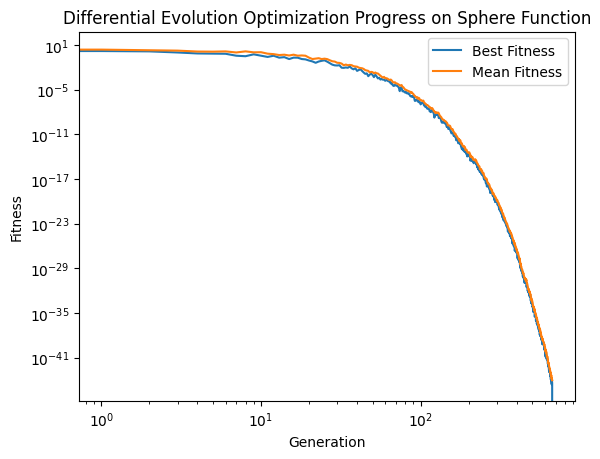

=== RASTRIGIN FUNCTION ===
Best solution found: tensor([ 6.9004e-05,  9.9498e-01,  9.9488e-01,  1.9900e+00,  2.9849e+00,
         9.9498e-01,  2.2828e-05,  1.9900e+00, -9.9487e-01, -9.9491e-01],
       device='cuda:0')
Best solution fitness: tensor(21.8891, device='cuda:0')



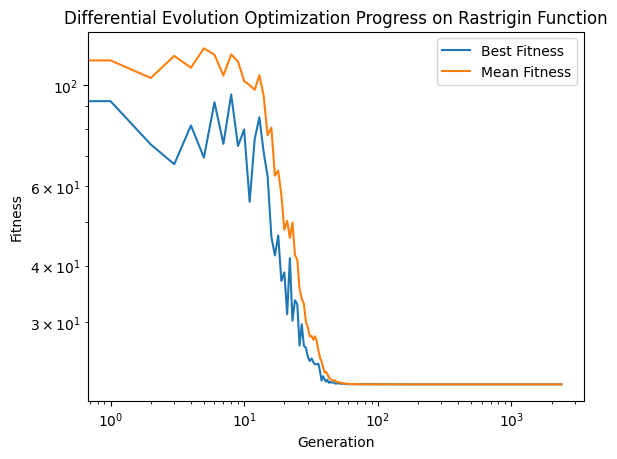

=== ROSENBROCK FUNCTION ===
Best solution found: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



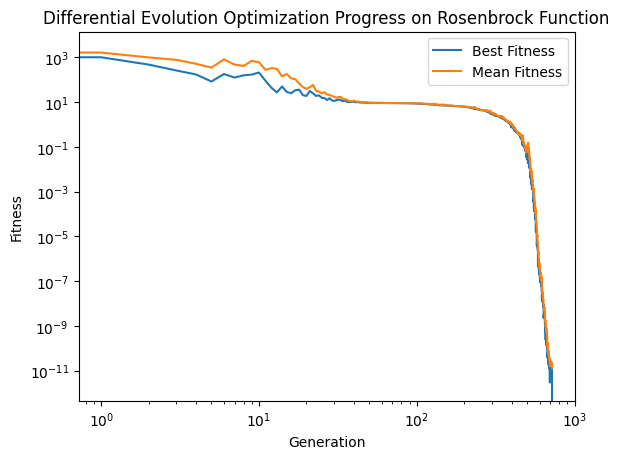

=== ACKLEY FUNCTION ===
Best solution found: tensor([ 1.1398e-06, -6.9976e-07, -7.0905e-07,  3.1746e-06, -7.5714e-07,
         1.3438e-06,  2.7423e-06,  1.7023e-06,  4.4086e-07,  2.1599e-07],
       device='cuda:0')
Best solution fitness: tensor(4.7684e-06, device='cuda:0')



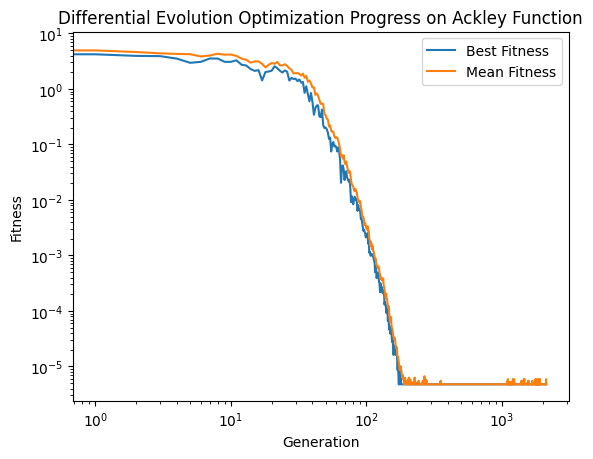

=== SCHWEFEL FUNCTION ===
Best solution found: tensor([5.2442, 5.2526, 5.2341, 5.2421, 5.2385, 5.2491, 5.2401, 5.2375, 5.2437,
        5.2216], device='cuda:0')
Best solution fitness: tensor(4150.3760, device='cuda:0')



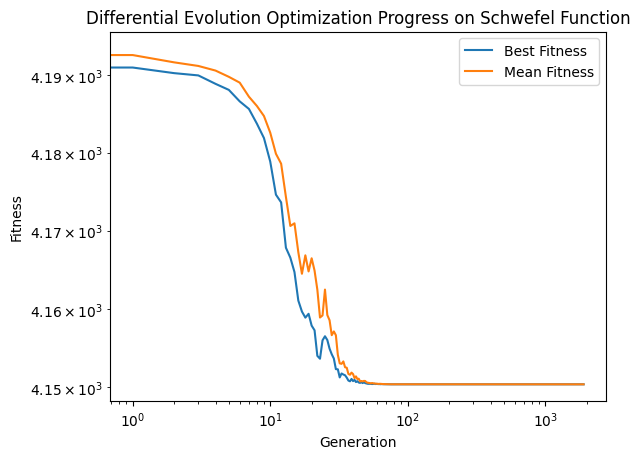

=== GRIEWANK FUNCTION ===
Best solution found: tensor([-4.2198e-05,  1.8482e-04, -4.5871e-05, -3.4434e-04,  3.7534e-04,
         4.9372e-04,  1.1618e-04, -4.9336e-04, -1.8448e-04, -1.5959e-04],
       device='cuda:0')
Best solution fitness: tensor(0., device='cuda:0')



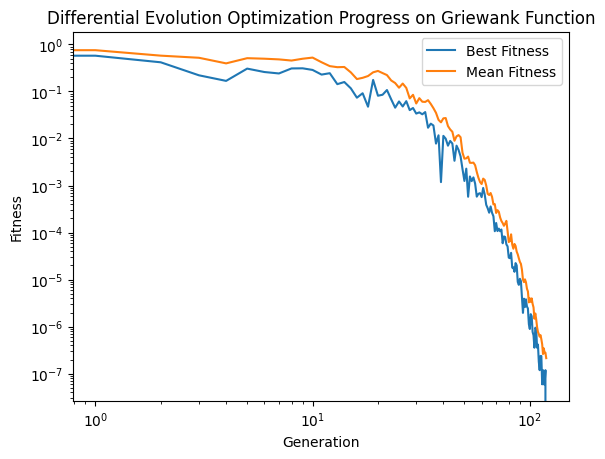

=== LEVY FUNCTION ===
Best solution found: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')
Best solution fitness: tensor(7.6427e-15, device='cuda:0')



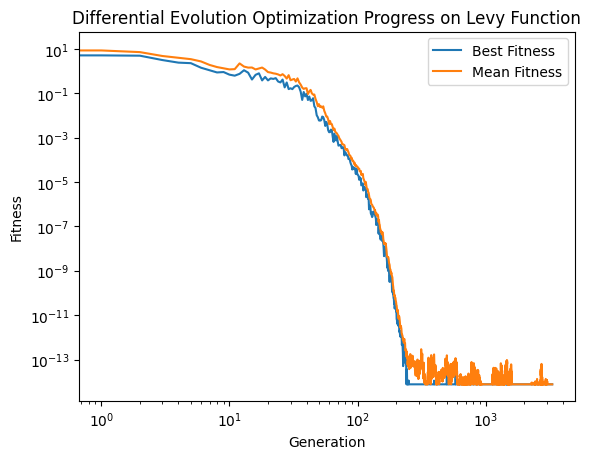

In [32]:
import matplotlib.pyplot as plt


for name, obj in objective_functions.items():
    solution = obj["solution"]
    best_solution, best_fitness, fitness_history = solution["best_solution"], solution["best_fitness"], solution["fitness_history"]
    best_fitness_history = fitness_history["best"]
    mean_fitness_history = fitness_history["mean"]

    print(f"=== {name.upper()} FUNCTION ===")
    print("Best solution found:", best_solution)
    print("Best solution fitness:", best_fitness)
    print()

    plt.plot(best_fitness_history, label="Best Fitness")
    plt.plot(mean_fitness_history, label="Mean Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(f"Differential Evolution Optimization Progress on {name.capitalize()} Function")
    plt.legend()
    plt.show()

# good
All but SCHWEFEL function are ok